In [7]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import os

sys.path.append(os.path.abspath(".."))


#from datasets.instereo2k import InStereo2KDataset

In [1]:
import os, importlib.util, pathlib

# найдем наш файл
candidates = [pathlib.Path.cwd(), *pathlib.Path.cwd().parents]
module_path = None
for base in candidates:
    p = base / "datasets" / "instereo2k.py"
    if p.exists():
        module_path = p
        break

assert module_path is not None, f"Не нашёл instereo2k.py. Текущая папка: {os.getcwd()}"

# загрузка модели напрямую 
spec = importlib.util.spec_from_file_location("instereo2k", str(module_path))
instereo2k = importlib.util.module_from_spec(spec)
spec.loader.exec_module(instereo2k)


InStereo2KDataset = instereo2k.InStereo2KDataset
print("Импортирован:", module_path)


Импортирован: /Users/olgashalashova/dl-cv-home-test/datasets/instereo2k.py


In [2]:
def show_triplet(sample, vmax=None):
    """Left RGB, Right RGB, and Disparity side by side."""
    left  = sample["left"].permute(1,2,0).numpy()   # (H,W,3) in [0,1]
    right = sample["right"].permute(1,2,0).numpy()  # (H,W,3) in [0,1]

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(left)
    axs[0].set_title(f"Left  |  id={sample['id']}")
    axs[0].axis("off")
    axs[1].imshow(right)
    axs[1].set_title("Right")
    axs[1].axis("off")

    if "disp" in sample:
        disp = sample["disp"].numpy()                # (H,W) float32 (pixels)
        mask = sample.get("mask", torch.ones_like(sample["disp"], dtype=torch.bool)).numpy()
        valid = np.isfinite(disp) & (disp > 0) & mask
        if vmax is None:
            vmax = np.percentile(disp[valid], 99) if valid.any() else float(np.max(disp))
        im = axs[2].imshow(np.ma.masked_where(~valid, disp), cmap="turbo", vmin=disp[disp > 0].min(), vmax=vmax)
        axs[2].set_title("Disparity (px)  —  brighter = closer")
        axs[2].axis("off")
        cbar = fig.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)
        cbar.set_label("pixels")
    else:
        axs[2].text(0.5, 0.5, "no disparity", ha="center", va="center")
        axs[2].axis("off")

    plt.tight_layout()
    plt.show()

def show_correspondence(sample, y=None, x=None):
    """Epipolar demo: pick (x,y) in left, show its match in right at x' = x - d(x,y)."""
    left  = sample["left"].permute(1,2,0).numpy()
    right = sample["right"].permute(1,2,0).numpy()
    disp  = sample["disp"].numpy()
    mask  = sample["mask"].numpy()
    H, W = disp.shape

    # choose a valid pixel near center if not provided
    if y is None: 
        y = H // 2
    if x is None:
        xs = np.where(mask[y])[0]
        if xs.size == 0:
            # pick any valid pixel in image
            ys = np.where(mask.any(axis=1))[0]
            y = int(np.median(ys)) if ys.size else H // 2
            xs = np.where(mask[y])[0]
        x = int(xs[len(xs)//2]) if xs.size else W // 2

    d = float(disp[y, x])
    xr = int(round(x - d))  # left→right correspondence at same row y

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].imshow(left)
    axs[0].axhline(y, color="lime", ls="--", lw=1)
    axs[0].plot([x], [y], "o", color="yellow")
    axs[0].set_title(f"Left: (x={x}, y={y})")
    axs[1].imshow(right)
    axs[1].axhline(y, color="lime", ls="--", lw=1)
    axs[1].plot([np.clip(xr,0,W-1)], [y], "o", color="yellow")
    axs[1].set_title(f"Right: (x'≈x−d={xr}, y={y})  |  d={d:.1f}px")
    for a in axs:
        a.axis("off")
    plt.tight_layout()
    plt.show()

In [3]:
dataset = InStereo2KDataset(
    root_dir="../data/instereo2k_sample",
    split="train",
    val_ratio=0.1,
    load_disp=True,          # show disparity
    disp_side="left",
    disp_divisor=100.0,      # set to 1.0 if PNG already stores pixel disparity
    resize_hw=(416, 608),    # fixed size for easy batching/visuals; or None
)

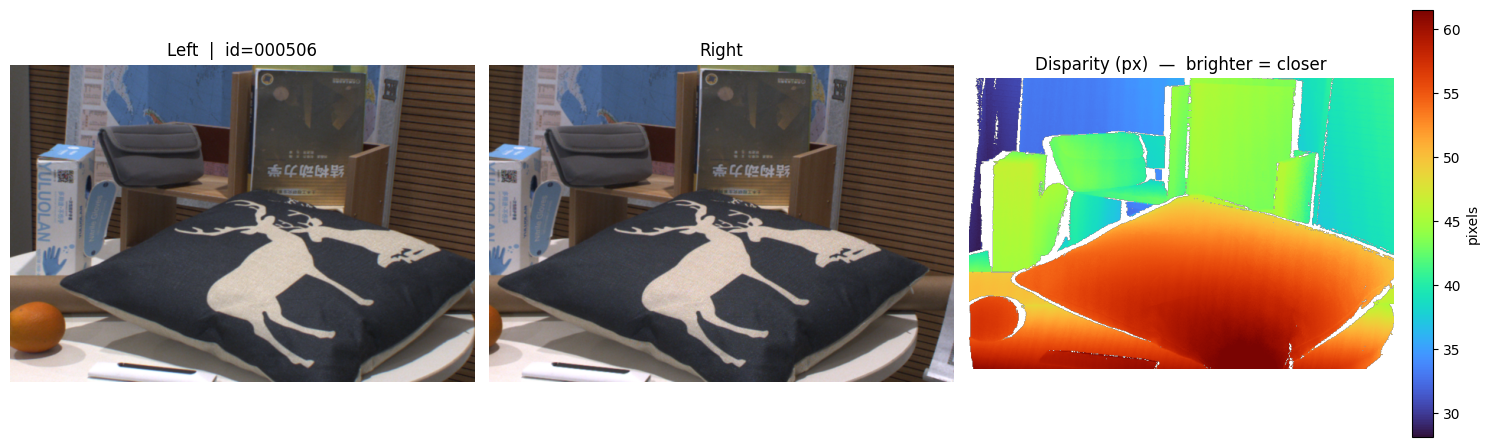

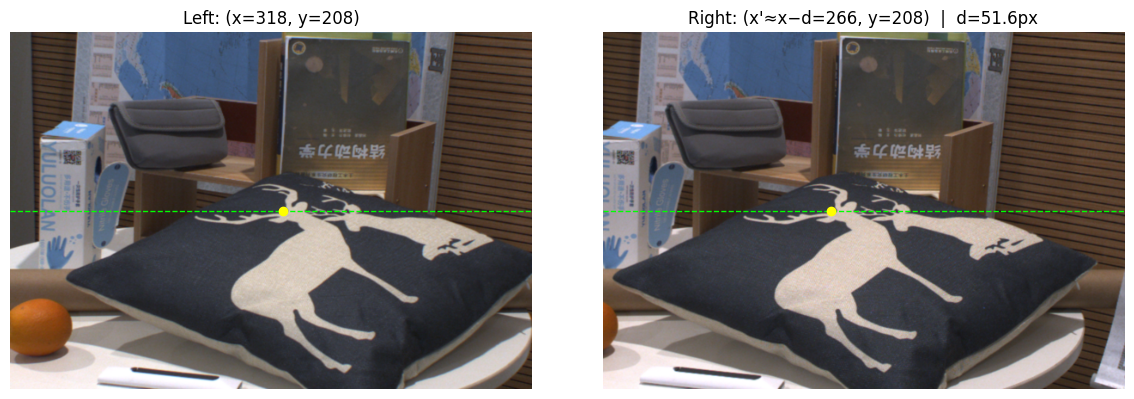

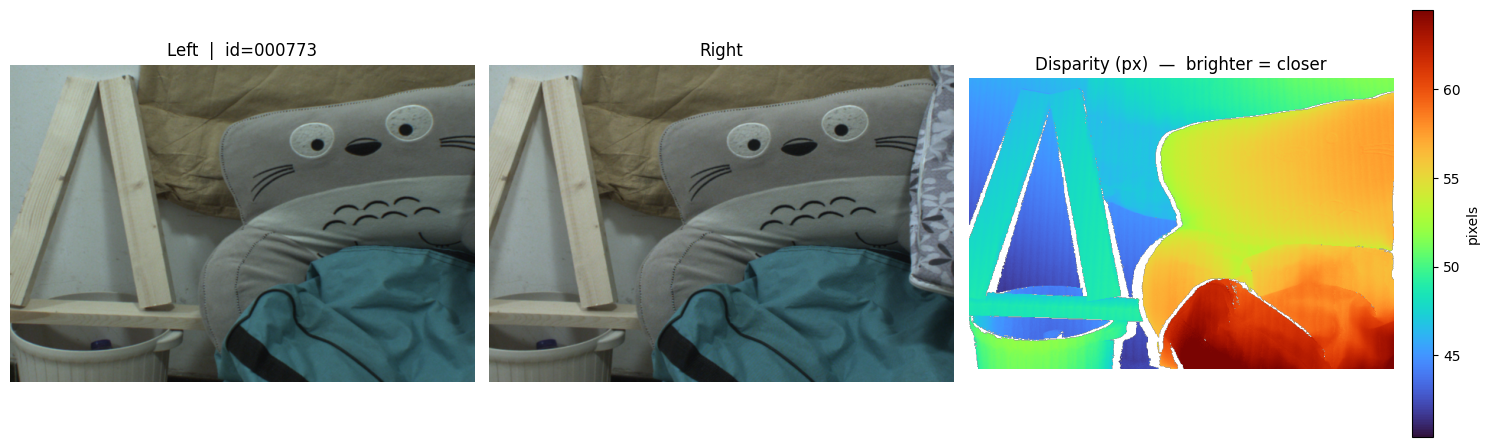

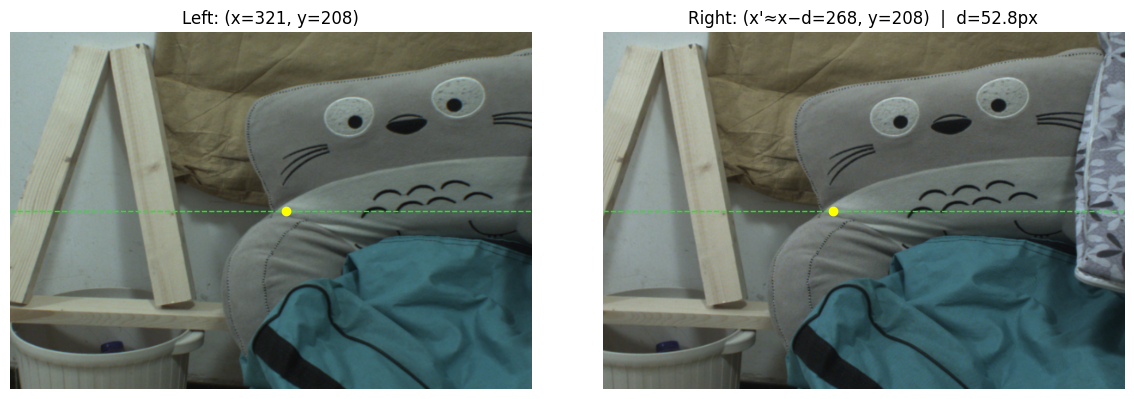

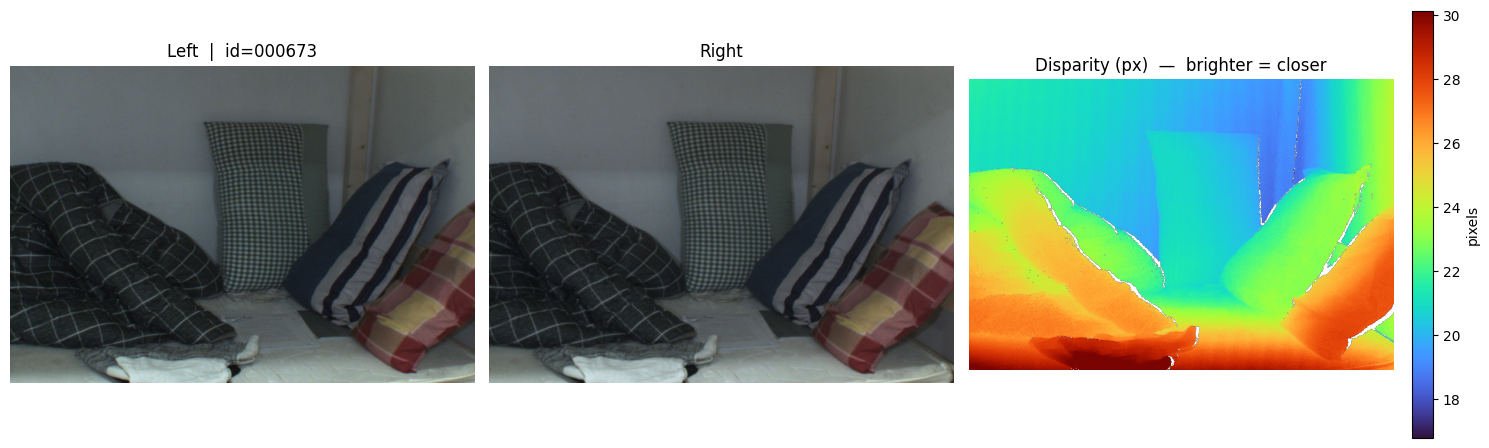

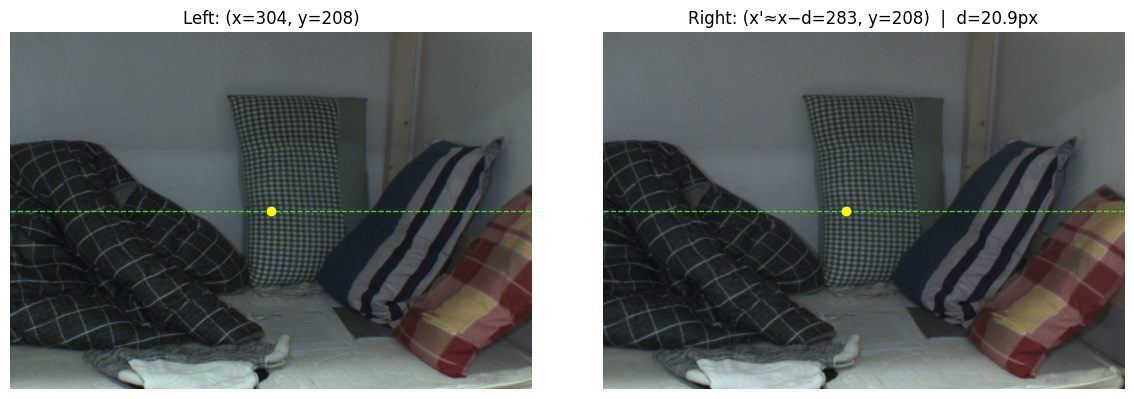

In [8]:
# --- Preview a few random samples ---
for i in np.random.randint(0, len(dataset), size=3):
    sample = dataset[i]
    show_triplet(sample)           # left, right, disparity
    show_correspondence(sample)    # visualize one matching point along same scanline